##### Sentinel-2（AWS Open Data）＋機械学習による時系列解析
##### Time-Series Analysis of Sentinel-2 (AWS Open Data) + Machine Learning

**登録不要、APIキー不要。Google Colab 上で実行可能** 実験時間約30分間

**No registration, no API keys. Runs on Google Colab.** The experiment takes approximately 30 minutes.

このノートブックは、**AWS Open Data** に公開されている Sentinel-2 L2A 画像（Cloud-Optimized GeoTIFF：COG 形式）を、無料で利用できる **Earth Search（STAC）API** を通じて取得します。
指定した関心領域（AOI）に対して月次 NDVI を算出し、時系列を可視化し、さらに簡単な機械学習手法を用いて予測や異常検知を行います。

This notebook pulls *Sentinel-2 L2A* imagery published as Cloud-Optimized GeoTIFFs (COGs) on the **Registry of Open Data on AWS**, discovered via the free **Earth Search (STAC) API**. It computes monthly NDVI over your Area of Interest (AOI), visualizes the time series, and applies simple ML for forecasting and anomaly detection.

**References**
- Sentinel-2 L2A COG dataset overview on AWS Open Data: https://registry.opendata.aws/sentinel-2-l2a-cogs/  
- Earth Search API (Element 84) description: https://element84.com/earth-search  
- Earth Search STAC API docs & endpoint: https://earth-search.aws.element84.com/v1/api.html  
- Reading COGs efficiently via HTTP with Rasterio: https://autogis-site.readthedocs.io/en/2020_/notebooks/Raster/read-cogs.html  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/test/

Mounted at /content/drive
/content/drive/MyDrive/test


## 1) Setup
Install required libraries (Colab will handle this).

In [ ]:
# If running on Colab, uncomment the next line to ensure GDAL/Rasterio binaries are present.
%pip -q install pystac-client rasterio rioxarray xarray geopandas shapely scikit-learn matplotlib pandas tqdm folium

import warnings, os, json, math, datetime as dt
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from shapely.geometry import Polygon, mapping
from pystac_client import Client
import rioxarray as rxr
import xarray as xr

plt.style.use('seaborn-v0_8')

API_URL = 'https://earth-search.aws.element84.com/v1'  # Earth Search STAC v1 endpoint

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 135.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.4/338.4 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 115.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 135.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.7/207.7 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.7/92.7 kB 10.1 MB/s eta 0:00:00


## 2) Set your Area of Interest (AOI) and time range
- Provide a polygon (GeoJSON) in EPSG:4326 (lat/lon).
- Choose dates and cloud cover threshold.

> **Tip:** Start with a small bounding box (e.g., a single district) and a shorter date range for faster runs.

In [ ]:
# --- USER PARAMETERS ---
# Example AOI: small box (replace with your coordinates)
min_lon, min_lat = 139.70, 35.60
max_lon, max_lat = 139.77, 35.64
aoi_coords = [[
    [min_lon, min_lat], [max_lon, min_lat], [max_lon, max_lat], [min_lon, max_lat], [min_lon, min_lat]
]]
AOI = {
    'type': 'Polygon',
    'coordinates': aoi_coords
}

START_DATE = '2022-01-01'
END_DATE   = '2024-12-31'
CLOUD_COVER_MAX = 20  # % threshold at item level
MAX_ITEMS = 60        # cap for demo; increase if needed

print('AOI set. Dates:', START_DATE, '→', END_DATE)


AOI set. Dates: 2022-01-01 → 2024-12-31


## 3) Discover Sentinel-2 L2A items via Earth Search (STAC)
We filter by collection, date, spatial intersection, and cloud cover.

- Collection: `sentinel-2-l2a` (Level-2A surface reflectance)  
- API supports temporal and spatial filters per STAC spec.  

In [ ]:
client = Client.open(API_URL)
search = client.search(
    collections=["sentinel-2-l2a"],
    intersects=AOI,
    datetime=f"{START_DATE}/{END_DATE}",
    max_items=MAX_ITEMS,
    query={'eo:cloud_cover': {'lt': CLOUD_COVER_MAX}}
)
items = list(search.get_items())
print(f'Found {len(items)} items')
# Build a small catalog table
rows = []
for it in items:
    dt_utc = pd.to_datetime(it.properties.get('datetime'))
    rows.append({
        'id': it.id,
        'datetime': dt_utc,
        'cloud_cover': it.properties.get('eo:cloud_cover', np.nan)
    })
cat_df = pd.DataFrame(rows).sort_values('datetime')
cat_df.head()


Found 60 items


,id,datetime,cloud_cover
59,S2A_54SUE_20220211_0_L2A,2022-02-11 01:37:21.329000+00:00,10.588447
58,S2B_54SUE_20220216_0_L2A,2022-02-16 01:37:15.992000+00:00,14.307068
57,S2A_54SUE_20220221_0_L2A,2022-02-21 01:37:24.176000+00:00,8.931391
56,S2B_54SUE_20220226_0_L2A,2022-02-26 01:37:18.144000+00:00,3.191559
55,S2A_54SUE_20220303_0_L2A,2022-03-03 01:37:25.889000+00:00,19.149812


## 4) NDVI per scene over the AOI
We compute NDVI = (NIR − RED) / (NIR + RED) using Sentinel-2 bands **B08 (NIR)** and **B04 (RED)**. Data assets are COGs accessible via HTTPS, so we stream only the needed window.  

> For simplicity we rely on low cloud cover items; masking with the *Scene Classification Layer (SCL)* can be added if desired.

In [ ]:
def compute_ndvi_for_item(item, aoi_geom):
    assets = item.assets
    # Check if required bands exist - using 'red' and 'nir' as per observed assets
    if 'red' not in assets or 'nir' not in assets:
        raise ValueError(f"Missing required bands (red or nir) in item assets. Available assets: {list(assets.keys())}")

    href_red = assets['red'].href
    href_nir = assets['nir'].href
    # Open as xarray with rioxarray; clip to AOI (EPSG:4326)
    red = rxr.open_rasterio(href_red, masked=True)
    nir = rxr.open_rasterio(href_nir, masked=True)
    # Align (reproject if needed)
    if str(red.rio.crs) != str(nir.rio.crs):
        nir = nir.rio.reproject(red.rio.crs)
    # Clip both to AOI
    red_clip = red.rio.clip([aoi_geom], crs='EPSG:4326', drop=True)
    nir_clip = nir.rio.clip([aoi_geom], crs='EPSG:4326', drop=True)
    # NDVI
    ndvi = (nir_clip.astype('float32') - red_clip.astype('float32')) / (nir_clip + red_clip + 1e-6)
    # Reduce to scalar (mean over AOI)
    val = float(ndvi.mean().values)
    return val

# Loop through items and compute NDVI
ts = []
for it in tqdm(items, desc='Computing NDVI'):
    try:
        ndvi_val = compute_ndvi_for_item(it, AOI)
        ts.append({'datetime': pd.to_datetime(it.properties['datetime']), 'ndvi': ndvi_val, 'id': it.id})
    except Exception as e:
        ts.append({'datetime': pd.to_datetime(it.properties['datetime']), 'ndvi': np.nan, 'id': it.id})
        print('Warning:', it.id, e)
ts_df = pd.DataFrame(ts).sort_values('datetime').dropna()
ts_df.head()

# Add a temporary inspection of one item's assets for debugging
if items:
    first_item = items[0]
    print(f"\nAssets for the first item ({first_item.id}): {list(first_item.assets.keys())}")

Computing NDVI:   0%|          | 0/60 [00:00<?, ?it/s]


Assets for the first item (S2A_54SUE_20241227_0_L2A): ['aot', 'blue', 'coastal', 'granule_metadata', 'green', 'nir', 'nir08', 'nir09', 'red', 'rededge1', 'rededge2', 'rededge3', 'scl', 'swir16', 'swir22', 'thumbnail', 'tileinfo_metadata', 'visual', 'wvp', 'aot-jp2', 'blue-jp2', 'coastal-jp2', 'green-jp2', 'nir-jp2', 'nir08-jp2', 'nir09-jp2', 'red-jp2', 'rededge1-jp2', 'rededge2-jp2', 'rededge3-jp2', 'scl-jp2', 'swir16-jp2', 'swir22-jp2', 'visual-jp2', 'wvp-jp2']


## 5) Monthly aggregation
Resample to **monthly median NDVI** and visualize.

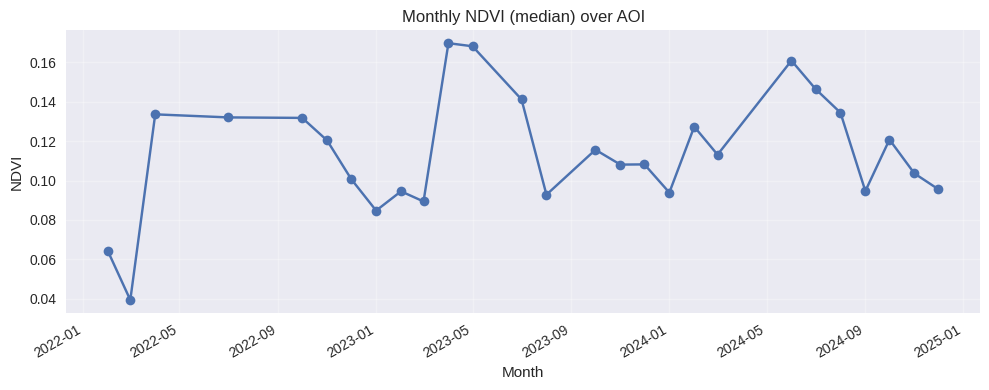

Saved monthly_ndvi.csv


In [ ]:
monthly = (ts_df.set_index('datetime')
           ['ndvi'].resample('MS')
           .median().to_frame()) # Select only 'ndvi' and convert back to DataFrame
monthly = monthly.dropna()

# Check if monthly DataFrame is empty before plotting
if not monthly.empty:
    fig, ax = plt.subplots(figsize=(10,4))
    monthly['ndvi'].plot(ax=ax, marker='o')
    ax.set_title('Monthly NDVI (median) over AOI')
    ax.set_ylabel('NDVI')
    ax.set_xlabel('Month')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    monthly.to_csv('monthly_ndvi.csv')
    print('Saved monthly_ndvi.csv')
else:
    print("Warning: No monthly NDVI data available to plot or save.")

## 6) Machine Learning
Two simple approaches:
- **Forecast** next months using a linear model with lag features.
- **Anomaly detection** with IsolationForest to flag unusual NDVI drops.

Forecast R2: -0.025258513107306868
MAE: 0.010596490354894638


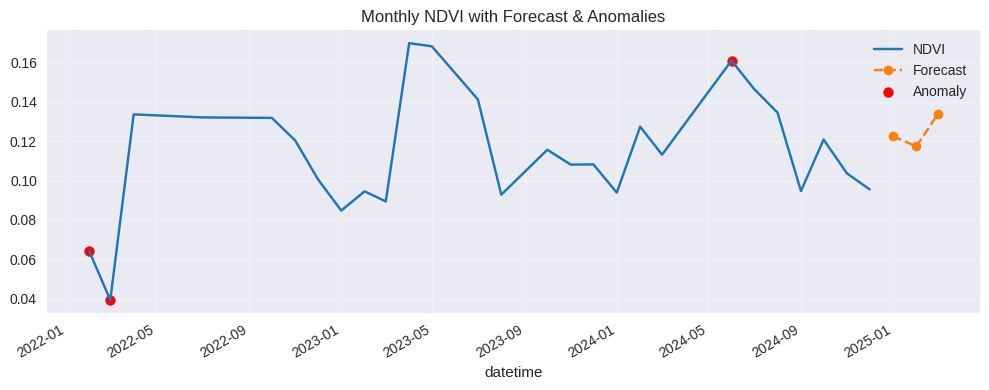

Saved ndvi_forecast.csv and monthly_ndvi_with_anomalies.csv


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import r2_score, mean_absolute_error

# Build lag features
m = monthly.copy()
for L in [1,2,3,4,5,6]:
    m[f'lag_{L}'] = m['ndvi'].shift(L)
m = m.dropna()
X = m[[f'lag_{L}' for L in [1,2,3,4,5,6]]]
y = m['ndvi']
split = int(len(m)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Forecast R2:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

# Predict next k months (roll-forward)
k = 3
last = monthly['ndvi'].copy()
lags = [last.shift(i).iloc[-1] for i in range(1,7)]
future_dates = pd.date_range(monthly.index.max()+pd.offsets.MonthBegin(1), periods=k, freq='MS')
future_vals = []
for _ in range(k):
    Xf = np.array(lags).reshape(1,-1)
    yhat = float(lr.predict(Xf))
    future_vals.append(yhat)
    # update lags
    lags = [yhat] + lags[:-1]

forecast_df = pd.DataFrame({'ndvi_forecast': future_vals}, index=future_dates)

# Anomaly detection on full monthly series
iso = IsolationForest(contamination=0.1, random_state=42)
anom_labels = iso.fit_predict(monthly[['ndvi']])
monthly['anomaly'] = (anom_labels == -1)

fig, ax = plt.subplots(figsize=(10,4))
monthly['ndvi'].plot(ax=ax, color='tab:blue', label='NDVI')
forecast_df['ndvi_forecast'].plot(ax=ax, color='tab:orange', marker='o', linestyle='--', label='Forecast')
ax.scatter(monthly.index[monthly['anomaly']], monthly['ndvi'][monthly['anomaly']],
           color='red', s=50, label='Anomaly')
ax.set_title('Monthly NDVI with Forecast & Anomalies')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('ndvi_forecast_anomalies.png', dpi=160)
plt.show()

forecast_df.to_csv('ndvi_forecast.csv')
monthly.to_csv('monthly_ndvi_with_anomalies.csv')
print('Saved ndvi_forecast.csv and monthly_ndvi_with_anomalies.csv')

## 7) (Optional) Visual check: one scene clipped to AOI
Display a quick-look RGB (B04,B03,B02) for the first item.

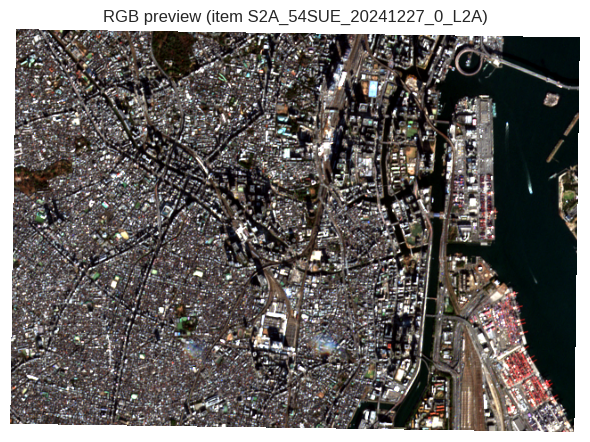

Saved rgb_preview.png


In [ ]:
if len(items):
    it0 = items[0]
    # Use 'red', 'green', 'blue' instead of 'B04', 'B03', 'B02'
    b4 = rxr.open_rasterio(it0.assets['red'].href, masked=True).rio.clip([AOI], crs='EPSG:4326', drop=True)
    b3 = rxr.open_rasterio(it0.assets['green'].href, masked=True).rio.clip([AOI], crs='EPSG:4326', drop=True)
    b2 = rxr.open_rasterio(it0.assets['blue'].href, masked=True).rio.clip([AOI], crs='EPSG:4326', drop=True)
    # Simple contrast stretch
    def stretch(x):
        p2, p98 = np.nanpercentile(x, (2, 98))
        x = np.clip((x - p2) / (p98 - p2 + 1e-6), 0, 1)
        return x
    rgb = np.dstack([stretch(b4.squeeze()), stretch(b3.squeeze()), stretch(b2.squeeze())])
    plt.figure(figsize=(6,6))
    plt.imshow(rgb)
    plt.title(f'RGB preview (item {it0.id})')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('rgb_preview.png', dpi=160)
    plt.show()
    print('Saved rgb_preview.png')